In [53]:
!pip install pyspellchecker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 42.4 MB/s eta 0:00:00


In [54]:
import json
import pandas as pd
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from sklearn.preprocessing import LabelEncoder
from spellchecker import SpellChecker

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [55]:
with open('/content/drive/MyDrive/BEAUSKIN ML/skin_treatment.json') as file:
    data = json.load(file)

In [56]:
print(data)

{'intents': [{'tag': 'greeting', 'input': ['Hi', 'Hello', 'Hey', 'Good morning', 'Good evening', 'Hi there', 'Hello there', 'Greetings'], 'responses': ['Hello! How can I assist you with your skincare today?', 'Hi there! How can I help with your skincare routine?', 'Hey! What skincare help do you need today?', 'Good to see you! What skincare questions do you have?']}, {'tag': 'common_skin_issues', 'input': ['What are common skin issues?', 'What are the most common skin problems?', 'What issues do people usually have with their skin?', 'What skin concerns should I be aware of?', 'What are common problems with skin care?'], 'responses': ['Some common skin issues include acne, dry skin, oily skin, hyperpigmentation, and signs of aging like wrinkles and fine lines.', "Skin problems can range from acne and dryness to oily skin, enlarged pores, and redness. It's important to understand your specific skin type to address these issues effectively.", 'The most common skin concerns are acne, dry 

In [57]:
# Initialize spellchecker
spell = SpellChecker()

# Function to correct spelling
def correct_spelling(text):
    words = text.split()
    corrected_words = [spell.correction(word) for word in words]
    return " ".join(corrected_words)

In [58]:
# Prepare the inputs and tags
tags = []
inputs = []
responses = {}
for intent in data['intents']:
    responses[intent['tag']] = intent['responses']
    for lines in intent['input']:
        inputs.append(lines)
        tags.append(intent['tag'])

In [59]:
df = pd.DataFrame({"inputs": inputs, "tags": tags})

In [60]:
df

,inputs,tags
0,Hi,greeting
1,Hello,greeting
2,Hey,greeting
3,Good morning,greeting
4,Good evening,greeting
...,...,...
121,See you,goodbye
122,Bye,goodbye
123,Take care,goodbye
124,Talk to you later,goodbye


preprocessing

In [61]:
#removing punctuations
import string
df['inputs'] = df['inputs'].apply(lambda wrd: [ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
df['inputs'] = df['inputs'].apply(lambda wrd: ''.join(wrd))
df

,inputs,tags
0,hi,greeting
1,hello,greeting
2,hey,greeting
3,good morning,greeting
4,good evening,greeting
...,...,...
121,see you,goodbye
122,bye,goodbye
123,take care,goodbye
124,talk to you later,goodbye


In [62]:
# Tokenization
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(df['inputs'])
train = tokenizer.texts_to_sequences(df['inputs'])

# Apply padding
x_train = pad_sequences(train)

# Encode the output
le = LabelEncoder()
y_train = le.fit_transform(df['tags'])

input_shape = x_train.shape[1]
print(input_shape)

# Define vocabulary
vocabulary = len(tokenizer.word_index)
print("Number of unique words: ", vocabulary)
output_length = le.classes_.shape[0]
print("Output length: ", output_length)

13
Number of unique words:  127
Output length:  21


neural network

In [65]:
i = Input(shape=(input_shape,))
x = Embedding(input_dim=vocabulary + 1, output_dim=128)(i)
x = LSTM(64, return_sequences=False)(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dense(output_length, activation='softmax')(x)

model = Model(inputs=i, outputs=x)

In [66]:
# Model summary
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 13)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_6 (Embedding)              │ (None, 13, 128)             │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 21)                  │           1,365 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 71,317 (278.58 KB)

 Trainable params: 71,317 (278.58 KB)

 Non-trainable params: 0 (0.00 B)

In [67]:
#compiling the model
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [69]:
#training the model
train = model.fit(x_train,y_train,epochs=150)

Epoch 1/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0163
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0144
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0127
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0124
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0097
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0093
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0097
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0090
Epoch 9/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0097
Epoch 10/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0105
Epoch 11/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0077 
Epoch 12/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - lo

Text(0.5, 0, 'epoch')

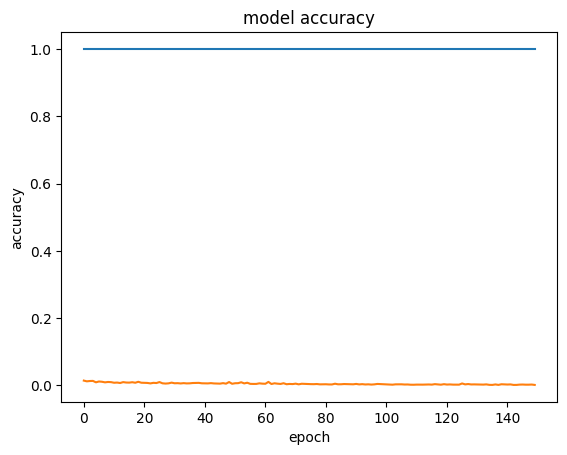

In [70]:
#plot accuracy
plt.plot(train.history['accuracy'], label='training set accuracy')
plt.plot(train.history['loss'], label='training set loss')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

In [80]:
while True:
    texts_p = []
    prediction_input = input('You : ')

    # Removing punctuation and converting to lowercase
    prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
    prediction_input = ''.join(prediction_input)
    texts_p.append(prediction_input)

    # Tokenizing and padding
    prediction_input = tokenizer.texts_to_sequences(texts_p)
    prediction_input = np.array(prediction_input).reshape(-1)
    prediction_input = pad_sequences([prediction_input], input_shape)

    # Getting output from model
    output = model.predict(prediction_input)
    output = output.argmax()

    # Finding the right tag and predicting the response
    response_tag = le.inverse_transform([output])[0]
    print("beauskin: ", random.choice(responses[response_tag]))

    # Check for "goodbye" tag to end the conversation
    if response_tag == "goodbye":
        break

You : hi
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
beauskin:  Hey! What skincare help do you need today?
You : i wanna know my skin type
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
beauskin:  To determine your skin type, wash your face with a gentle cleanser, wait for about an hour without applying any products, then observe your skin. If it feels tight or flaky, you have dry skin. If it’s shiny all over, you have oily skin. If only your T-zone (forehead, nose, chin) is shiny, you likely have combination skin. If it feels comfortable and balanced, you have normal skin. For an easier way, try using the face scan analysis feature in our Beauskin app. It can detect your skin type and provide insights about acne concerns.
You : i have oily skin
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
beauskin:  Avoid harsh scrubs that can trigger more oil production. Use mattifying primers or powders to control shine during the day.
You : i have acne
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
beauskin:  Managing acne requi

In [81]:
print(tf.__version__)

2.17.1


In [82]:
model.save('/content/drive/MyDrive/BEAUSKIN ML/models/chatbot_model_new.h5')

In [84]:
# Save tokenizer to JSON file
tokenizer_json = tokenizer.to_json()
with open('/content/drive/MyDrive/BEAUSKIN ML/models/tokenizer.json', 'w') as json_file:
    json.dump(tokenizer_json, json_file)

print("Tokenizer saved successfully as 'tokenizer.json'")


Tokenizer saved successfully as 'tokenizer.json'
